**VIS + NIR tutorial** 

For dual VIS/NIR workflows, a visible image is used to identify an image mask for the plant material. We use a landmark transformation to place the VIS image mask over the NIR image. This allows two workflows to be done at once and also allows plant material to be identified in low-quality images. We do not recommend this approach if there is a lot of plant movement between capture of NIR and VIS images.


In [ ]:
import os

# Detect notebook environment
def detect_notebook_environment():
    if 'COLAB_GPU' in os.environ:
        print('Google Colaboratory detected.')
        %pip install "altair>=5" ipympl plantcv
        
        # Give access and mount your Google Drive (need a Google Account)
        from google.colab import drive
        drive.mount('/content/gdrive')
        
        # Enable widget feature with matplotlib
        from google.colab import output
        output.enable_custom_widget_manager()
        
        #View working directory, may need to change
        %pwd
    else:
        print('Binder detected.')

environment = detect_notebook_environment()

In [1]:
#Import the needed packages needed to run 

%matplotlib widget
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs


In [2]:
#Import a sample image and define it to be used in the notebook
args = WorkflowInputs(
    images=["./sample_images/VIS_SV_0_z1_h1_g0_e77_v500_84572_0.png",
            "./sample_images/NIR_SV_0_z1_h1_g0_e21500_v500_84575_0.png"],
    names="vis,nir",
    result="data_output.csv",
    outdir="img_output",
    writeimg=False,
    debug="plot"
)


In [3]:
# Set debug to the global parameter 
pcv.params.debug = args.debug

# Change the display settings
pcv.params.dpi = 100
pcv.params.text_size = 20
pcv.params.text_thickness = 20
pcv.params.debug_outdir = args.outdir

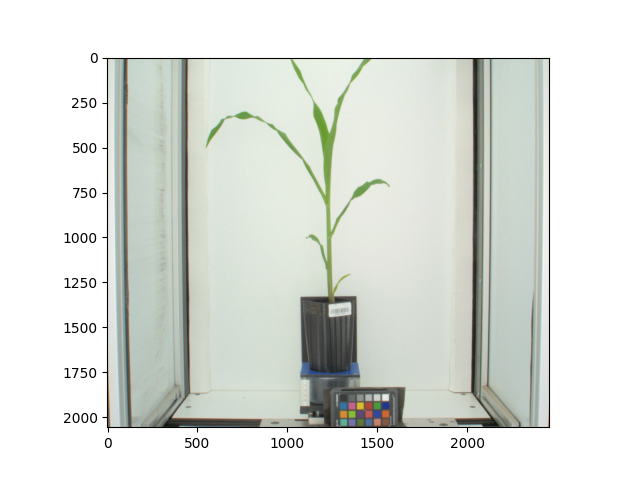

In [4]:
# Read VIS image 

# Filename - Image file to be read in  
img, path, filename = pcv.readimage(filename=args.vis)

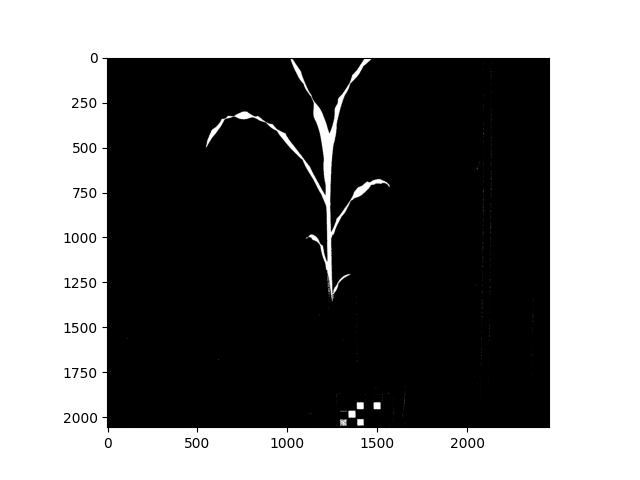

In [5]:
# Threshold 1
thresh1 = pcv.threshold.dual_channels(rgb_img = img, x_channel = "a", 
                                      y_channel = "b", 
                                      points = [(100,130),(130,175)], 
                                      above=True)

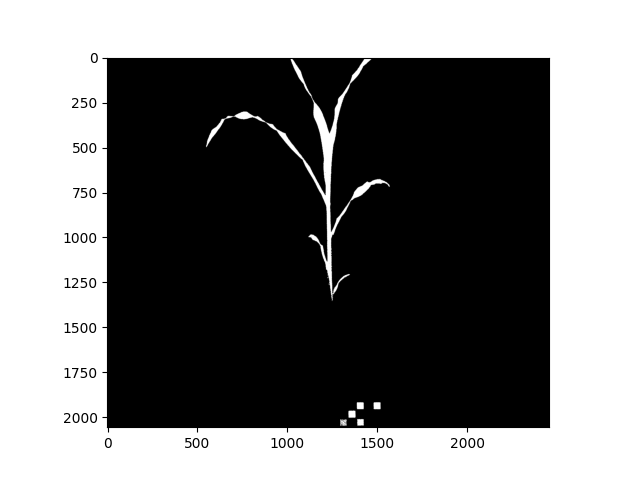

In [6]:
# Remove Noise
thresh1_fill = pcv.fill(bin_img=thresh1, size=300)

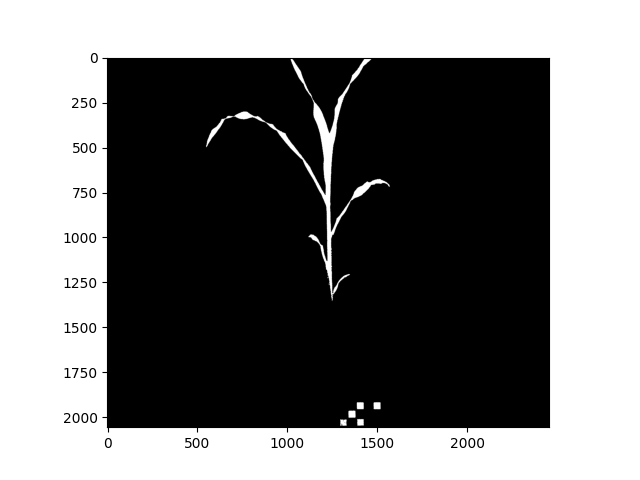

In [7]:
# Fill in small objects 
thresh1_filled_holes = pcv.closing(gray_img=thresh1_fill)

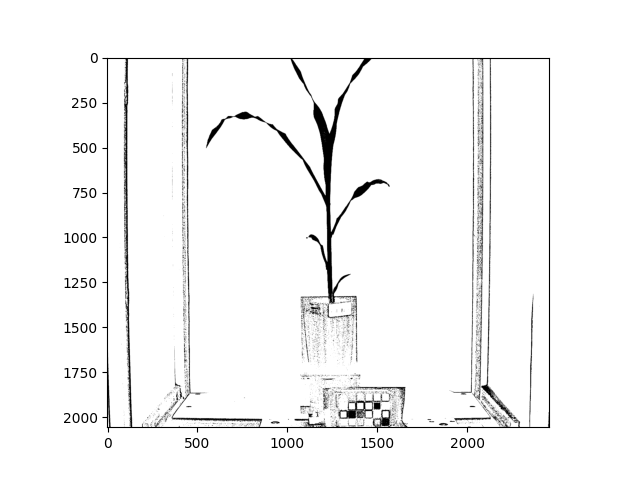

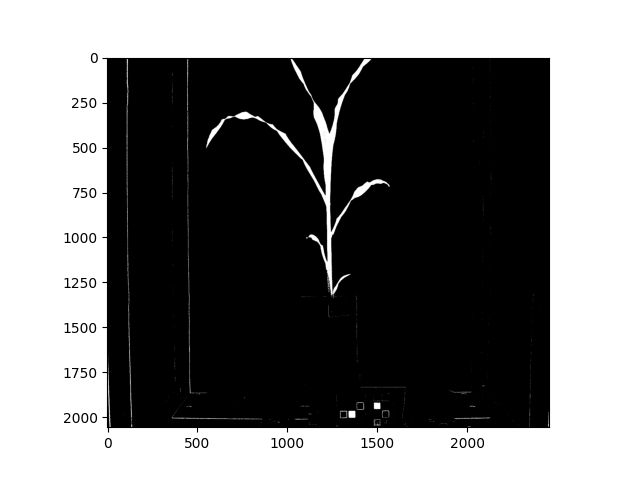

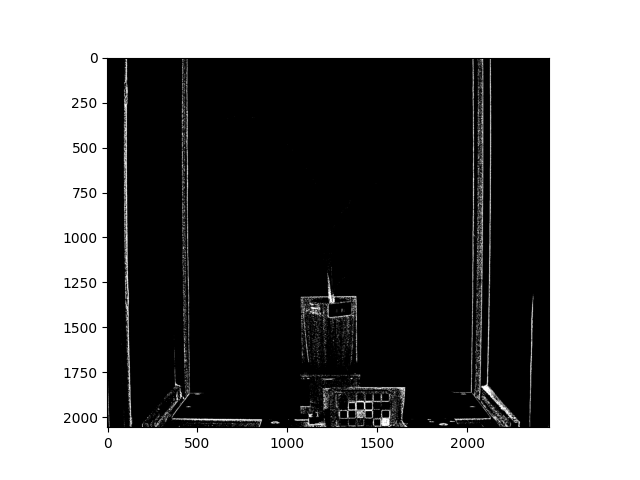

In [8]:
# Threshold using Naive Bayes

thresh2 = pcv.naive_bayes_classifier(rgb_img=img, 
                                  pdf_file="./naive_bayes/maize_naive_bayes_pdfs_new.txt")


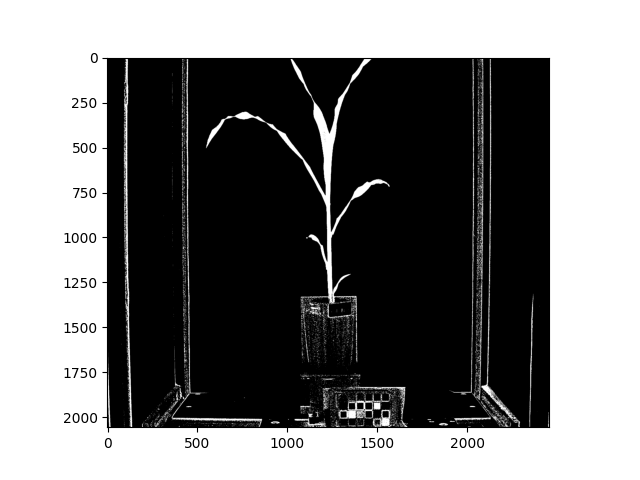

In [9]:
# Threshold 2
thresh2_plant = pcv.logical_or(thresh2['greenplant'], thresh2['purpleplant'])

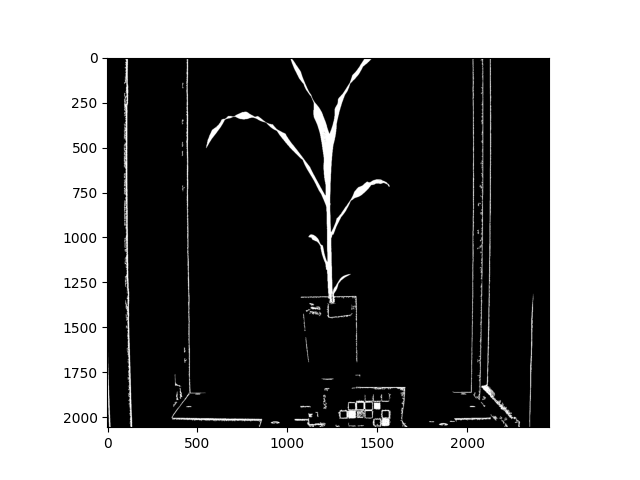

In [10]:
# Fill the naive bayes threshold
thresh2_fill = pcv.fill(bin_img=thresh2_plant, size=100)

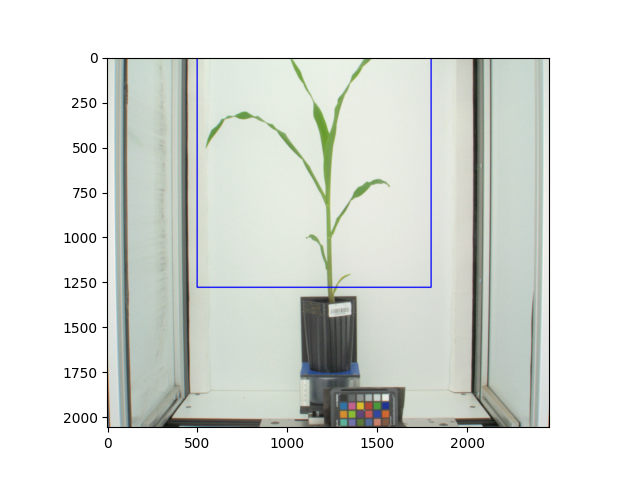

In [11]:
# Define ROI - utilizes Objects
roi = pcv.roi.rectangle(img=img, x=500, y=5, h=1275, w=1300)

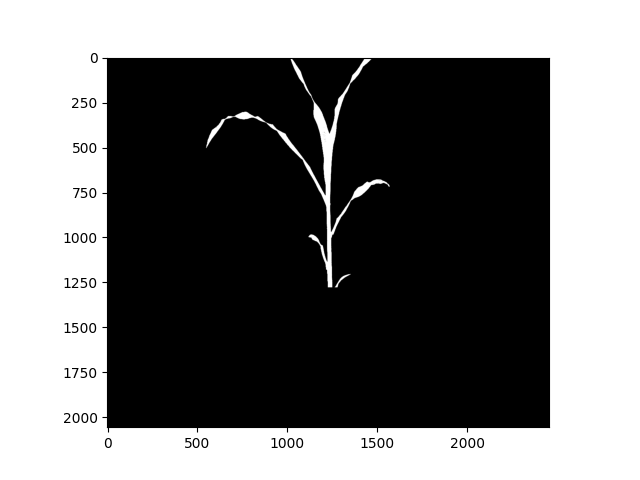

In [12]:
# Filter binary image to make a clean mask
mask = pcv.roi.filter(mask=thresh2_fill, roi=roi,
roi_type="cutto")

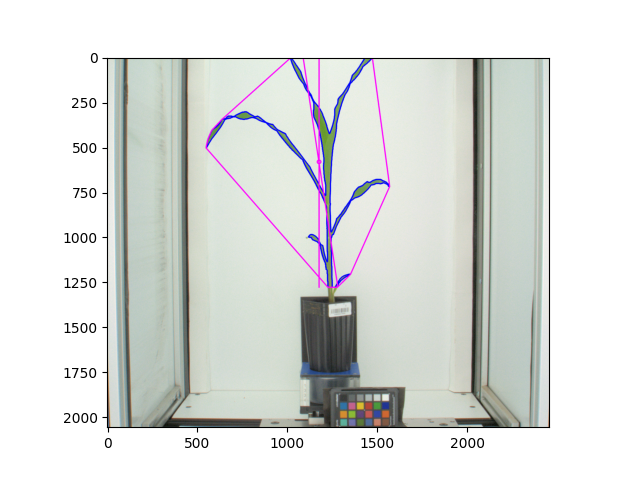

In [13]:
############### VIS (RGB) Analysis ################ 
shape_img = pcv.analyze.size(img=img,labeled_mask=mask, n_labels=1)

In [14]:
# Determine color properties: Histograms, Color Slices and Pseudocolored Images, output color analyzed images (optional)

color_histogram = pcv.analyze.color(rgb_img=img, labeled_mask=mask, colorspaces='hsv', label="default")


alt.FacetChart(...)

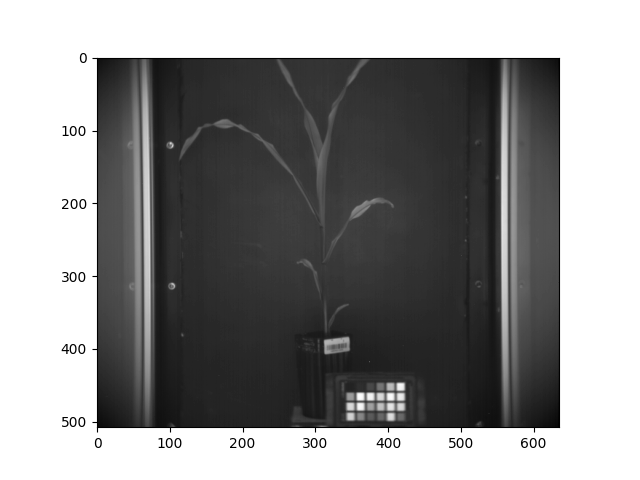

In [15]:
# Read in NIR image

nir, path1, filename1 = pcv.readimage(filename=args.nir, mode='native')

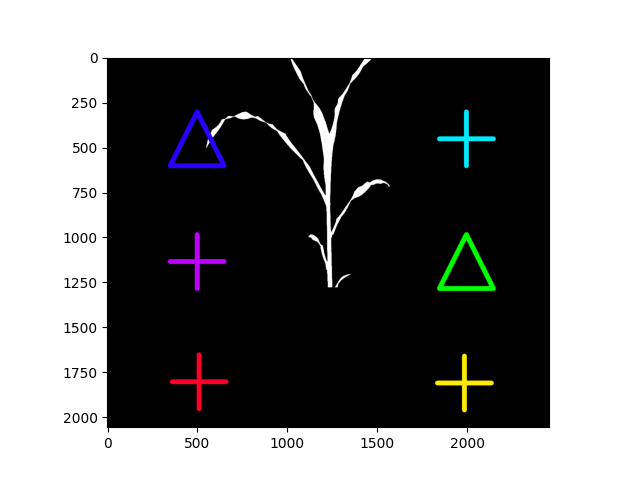

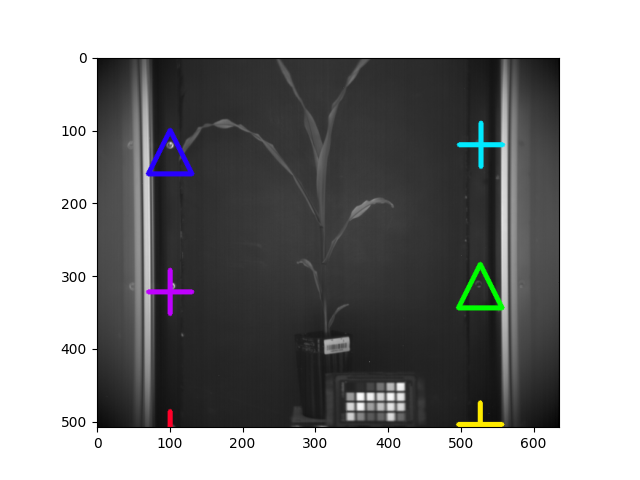

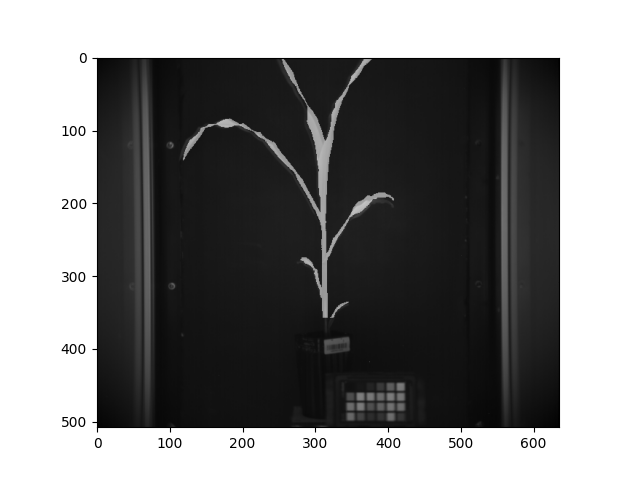

In [17]:
# Apply landmark transformation (we chose to use the screws in the background) to align both images 

img_warped, mat = pcv.transform.warp(img=mask, refimg=nir,
                                     pts = [(500, 454), (1995, 454), (1995, 1136), (1984, 1811), (511, 1804), 
                                            (500, 1136)],
                                     refpts = [(100, 130), (527, 120), (526, 314), (526, 504), (100, 516), 
                                               (100, 322)],
                                     method='lmeds')

In [18]:
# Analyze NIR pixel intensity values of the plant

nir_hist = pcv.analyze.grayscale(gray_img=nir, labeled_mask=img_warped, bins=100, label="NIR")

alt.FacetChart(...)

/srv/conda/envs/notebook/lib/python3.10/site-packages/plotnine/ggplot.py:365: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


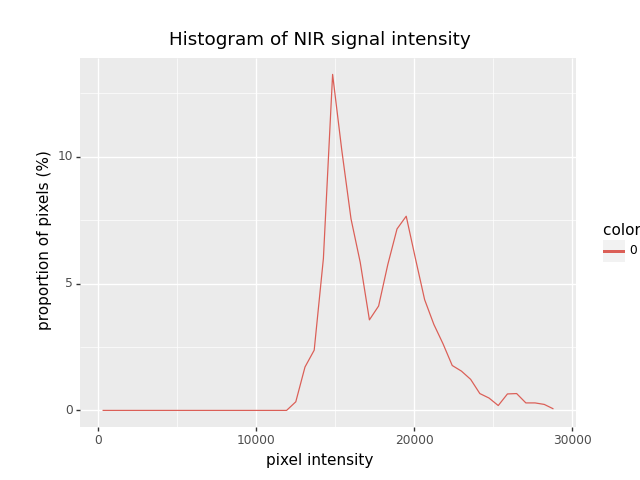

In [20]:
# Make a histogram visualization 

nir_hist = pcv.visualize.histogram(img=nir, mask=img_warped, lower_bound=0, upper_bound=None, bins=50, title="Histogram of NIR signal intensity")

In [21]:
# The save results function will take the measurements stored when running any PlantCV analysis functions, format, 
# and print an output text file for data analysis.

pcv.outputs.save_results(filename=args.result, outformat="csv")